In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import tensorflow as tf
import warnings
from sklearn.utils import shuffle
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sns
from scipy.stats import norm, gamma
from scipy import stats

warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-11-20 14:47:03.305396: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 14:47:03.337417: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 14:47:03.337463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 14:47:03.337484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 14:47:03.343023: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 14:47:03.343376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [12]:
def total_time(L):
    return len(L) * (1 / 50)

def lenght(L):
    return len(L)

def mean_norm(L):
    return np.mean(L)

def std_norm(L):
    return np.std(L)

def complete(L, n):
    for i in range(n):
        if (len(L) < i):
            np.append(L, 0)
    return L

def print_some_curve(feature, df1):
    print(f"{feature} infos :")
    df_feature = df1[df1['label'] == feature]
    print(df_feature.describe())
    for index, row in df_feature.head().iterrows():
        x = row['time']
        y = row['norm']
        plt.plot(x, y, label=f'curve {index + 1}')
    plt.xlabel('temps (s)')
    plt.ylabel(f'norm of {feature}')
    plt.legend()
    plt.title(f'Graphs from {feature}')
    plt.show()

def temps(liste):
    return [0 + i * (1 / 50) for i in range(len(liste))]

def convert_label_to_num(label):
    L = ['rest', 'walk', 'run', 'dribble', 'pass', 'cross', 'shot', 'tackle']
    return L.index(label)

def set_marker(label_num):
    L = ['o', 's', '+', 'x', '*', 'D', 'H', '>', '1']
    return L[label_num]

def convert_label_to_num(label):
    L = ['rest', 'walk', 'run', 'dribble', 'pass', 'cross', 'shot', 'tackle']
    return L.index(label)

### 1. Détails sur les deux matchs JSON 
Avec les hypothèses suivantes:
- Toutes les actions possibles, sont labélisées et enregistrées par le capteur 'meteor'.
- Il n'existe pas de temps de jeu entre deux actions.

On fait les conclusions suivantes:
- En moyenne, la durée d'une action est de 0.938 secondes.
- Les joueurs sur lesquels on a des mesures sont rentrés sur le terrain respectivement 556.94 et 560.12 secondes, soit 9 minutes chacun environ.

In [29]:
data1 = "../match/match_1.json"
data2 = "../match/match_2.json"
df1 = pd.read_json(data1)
df2 = pd.read_json(data2)

df1["id_action"] = df1.index
df2["id_action"] = df2.index

df1["total_time"] = df1['norm'].apply(total_time)
df2["total_time"] = df2['norm'].apply(total_time)

df1["total_time_cum"] = df1['total_time'].cumsum()
df2["total_time_cum"] = df2['total_time'].cumsum()

print("Mean total_time")
print(df1[['total_time']].mean())
print(df2[['total_time']].mean())

print("Maximum total_time_cum")
print(df1[['total_time_cum']].max())
print(df2[['total_time_cum']].max())

df1.drop(df1[df1['label'] == 'no action'].index, inplace=True)
df1.reset_index(drop=True, inplace=True)
df2.drop(df2[df2['label'] == 'no action'].index, inplace=True)
df2.reset_index(drop=True, inplace=True)

df = pd.concat([df1, df2])
df = df.reset_index(drop=True)

print("Mean total_time")
print(df[['total_time']].mean())

df["label_num"] = df['label'].apply(convert_label_to_num)
df["label_marker"] = df['label_num'].apply(set_marker)
df["size"] = df['norm'].apply(lenght)
df["mean_norm"] = df['norm'].apply(mean_norm)
df["std_norm"] = df['norm'].apply(std_norm)

print(np.sort(df["label"].unique()))  # ['cross', 'dribble', 'pass', 'rest', 'run', 'shot', 'tackle', 'walk']
actions = np.sort(df["label"].unique())
print(df["label"].value_counts())

df["time"] = df["norm"].apply(temps)
print(df[['norm', 'time', 'total_time_cum']])
print("Maximum size")
print(df[['size']].max()*(1/50))
print(df[['total_time']].max())
print("Minimum size")
print(df[['size']].mean()*(1/50))
print(df[['total_time']].mean())

Mean total_time
total_time    0.970279
dtype: float64
total_time    0.913736
dtype: float64
Maximum total_time_cum
total_time_cum    556.94
dtype: float64
total_time_cum    560.12
dtype: float64
Mean total_time
total_time    0.938143
dtype: float64
['cross' 'dribble' 'pass' 'rest' 'run' 'shot' 'tackle' 'walk']
label
run        552
walk       435
dribble     78
rest        35
pass        32
tackle      31
shot        18
cross        4
Name: count, dtype: int64
                                                   norm  \
0     [23.177037336396975, 23.361525285249378, 21.53...   
1     [20.998214383911275, 19.182798059840767, 18.27...   
2     [21.95259682019565, 20.62720484424047, 22.5554...   
3     [19.39209748358647, 19.30460665293087, 18.9787...   
4     [22.069263037713093, 19.672270483203395, 19.88...   
...                                                 ...   
1180  [23.337305769963503, 20.210987911153104, 25.06...   
1181  [22.470322813933603, 22.552427730975246, 23.84...   
1182 

# Données de normes 

- pour chacuns des labels, on remarque qu'il n'y a aucune corrélation entre la moyenne des normes des accélerations d'une action, et le moment (en temps) de l'action.


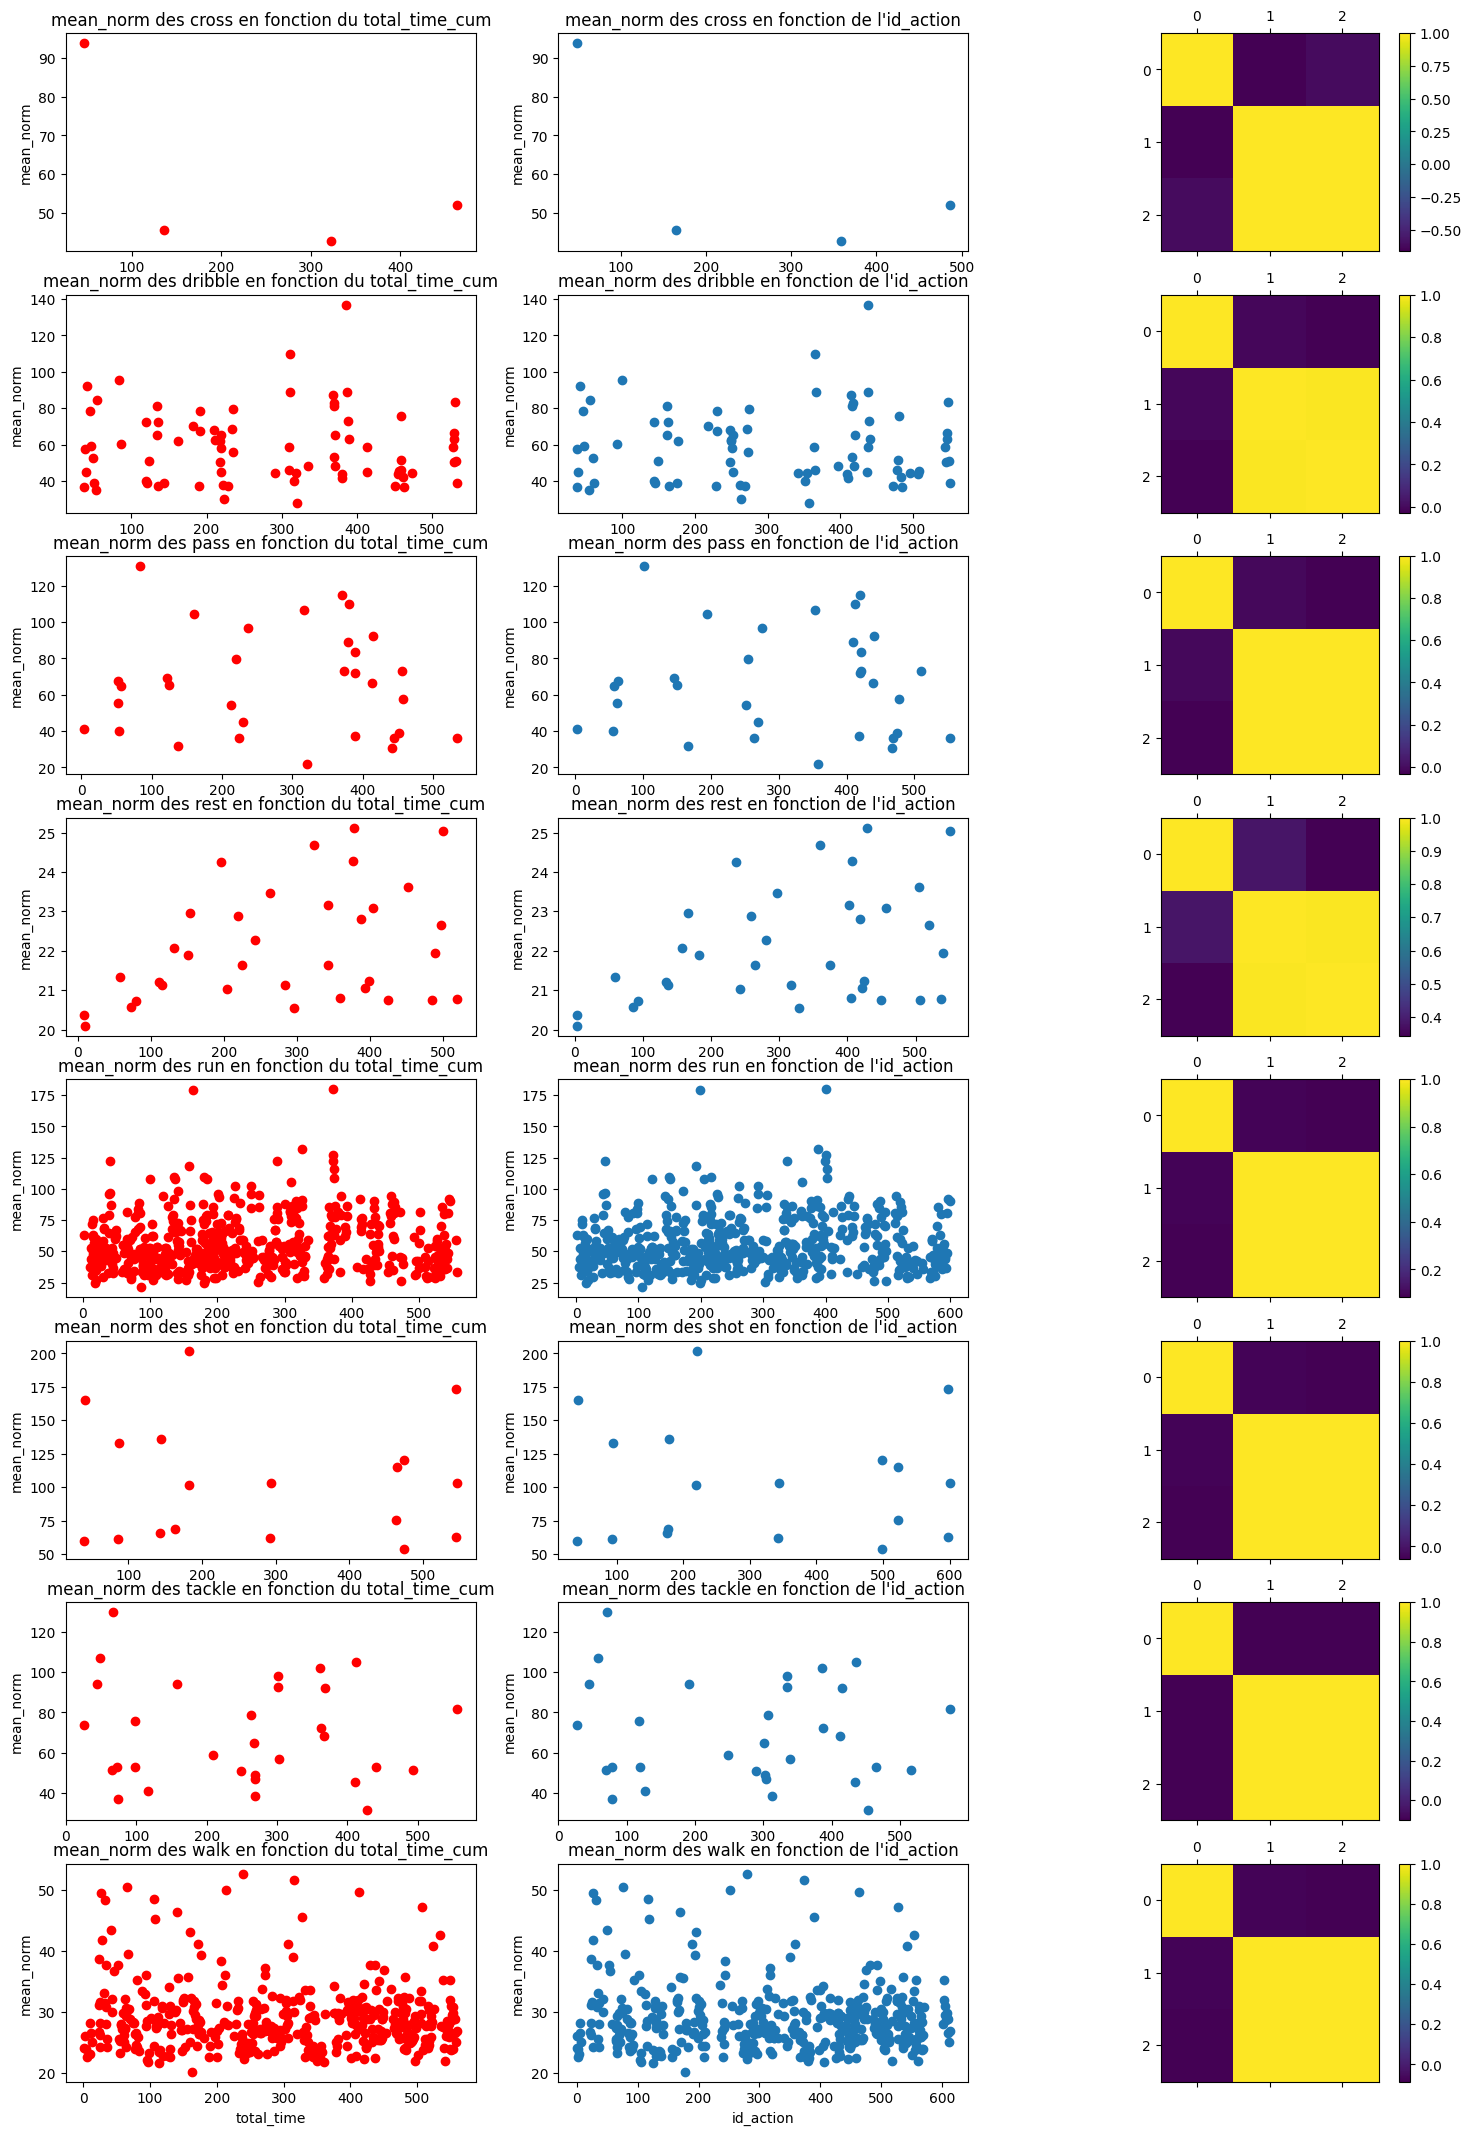

In [4]:
fig = plt.figure(figsize=(18,30))
i = 0
for action in actions:
    df3 = df[df['label'] == action][['mean_norm', 'id_action', 'total_time_cum']]

    ax1 = plt.subplot(len(actions)+1, 3, 1 + 3*i)
    ax2 = plt.subplot(len(actions)+1, 3, 2 + 3*i)
    ax3 = plt.subplot(len(actions)+1, 3, 3 + 3*i)

    ax1.scatter(df3['total_time_cum'], df3['mean_norm'], c='r')
    ax1.set_title(f"mean_norm des {action} en fonction du total_time_cum")
    ax1.set_ylabel('mean_norm')

    ax2.scatter(df3['id_action'], df3['mean_norm'])
    ax2.set_title(f"mean_norm des {action} en fonction de l'id_action")
    ax2.set_ylabel('mean_norm')
    i += 1
    
    corr_df3 = df3.corr()
    plt3 = ax3.matshow(corr_df3)
    fig.colorbar(plt3, orientation='vertical')

ax1.set_xlabel('total_time')
ax2.set_xlabel('id_action')
plt.show()

- pour chacuns des labels, on remarque qu'il n'y a aucune corrélation entre la durée d'une action et le moment de l'action.

Text(0.5, 24.140624999999822, 'id_action')

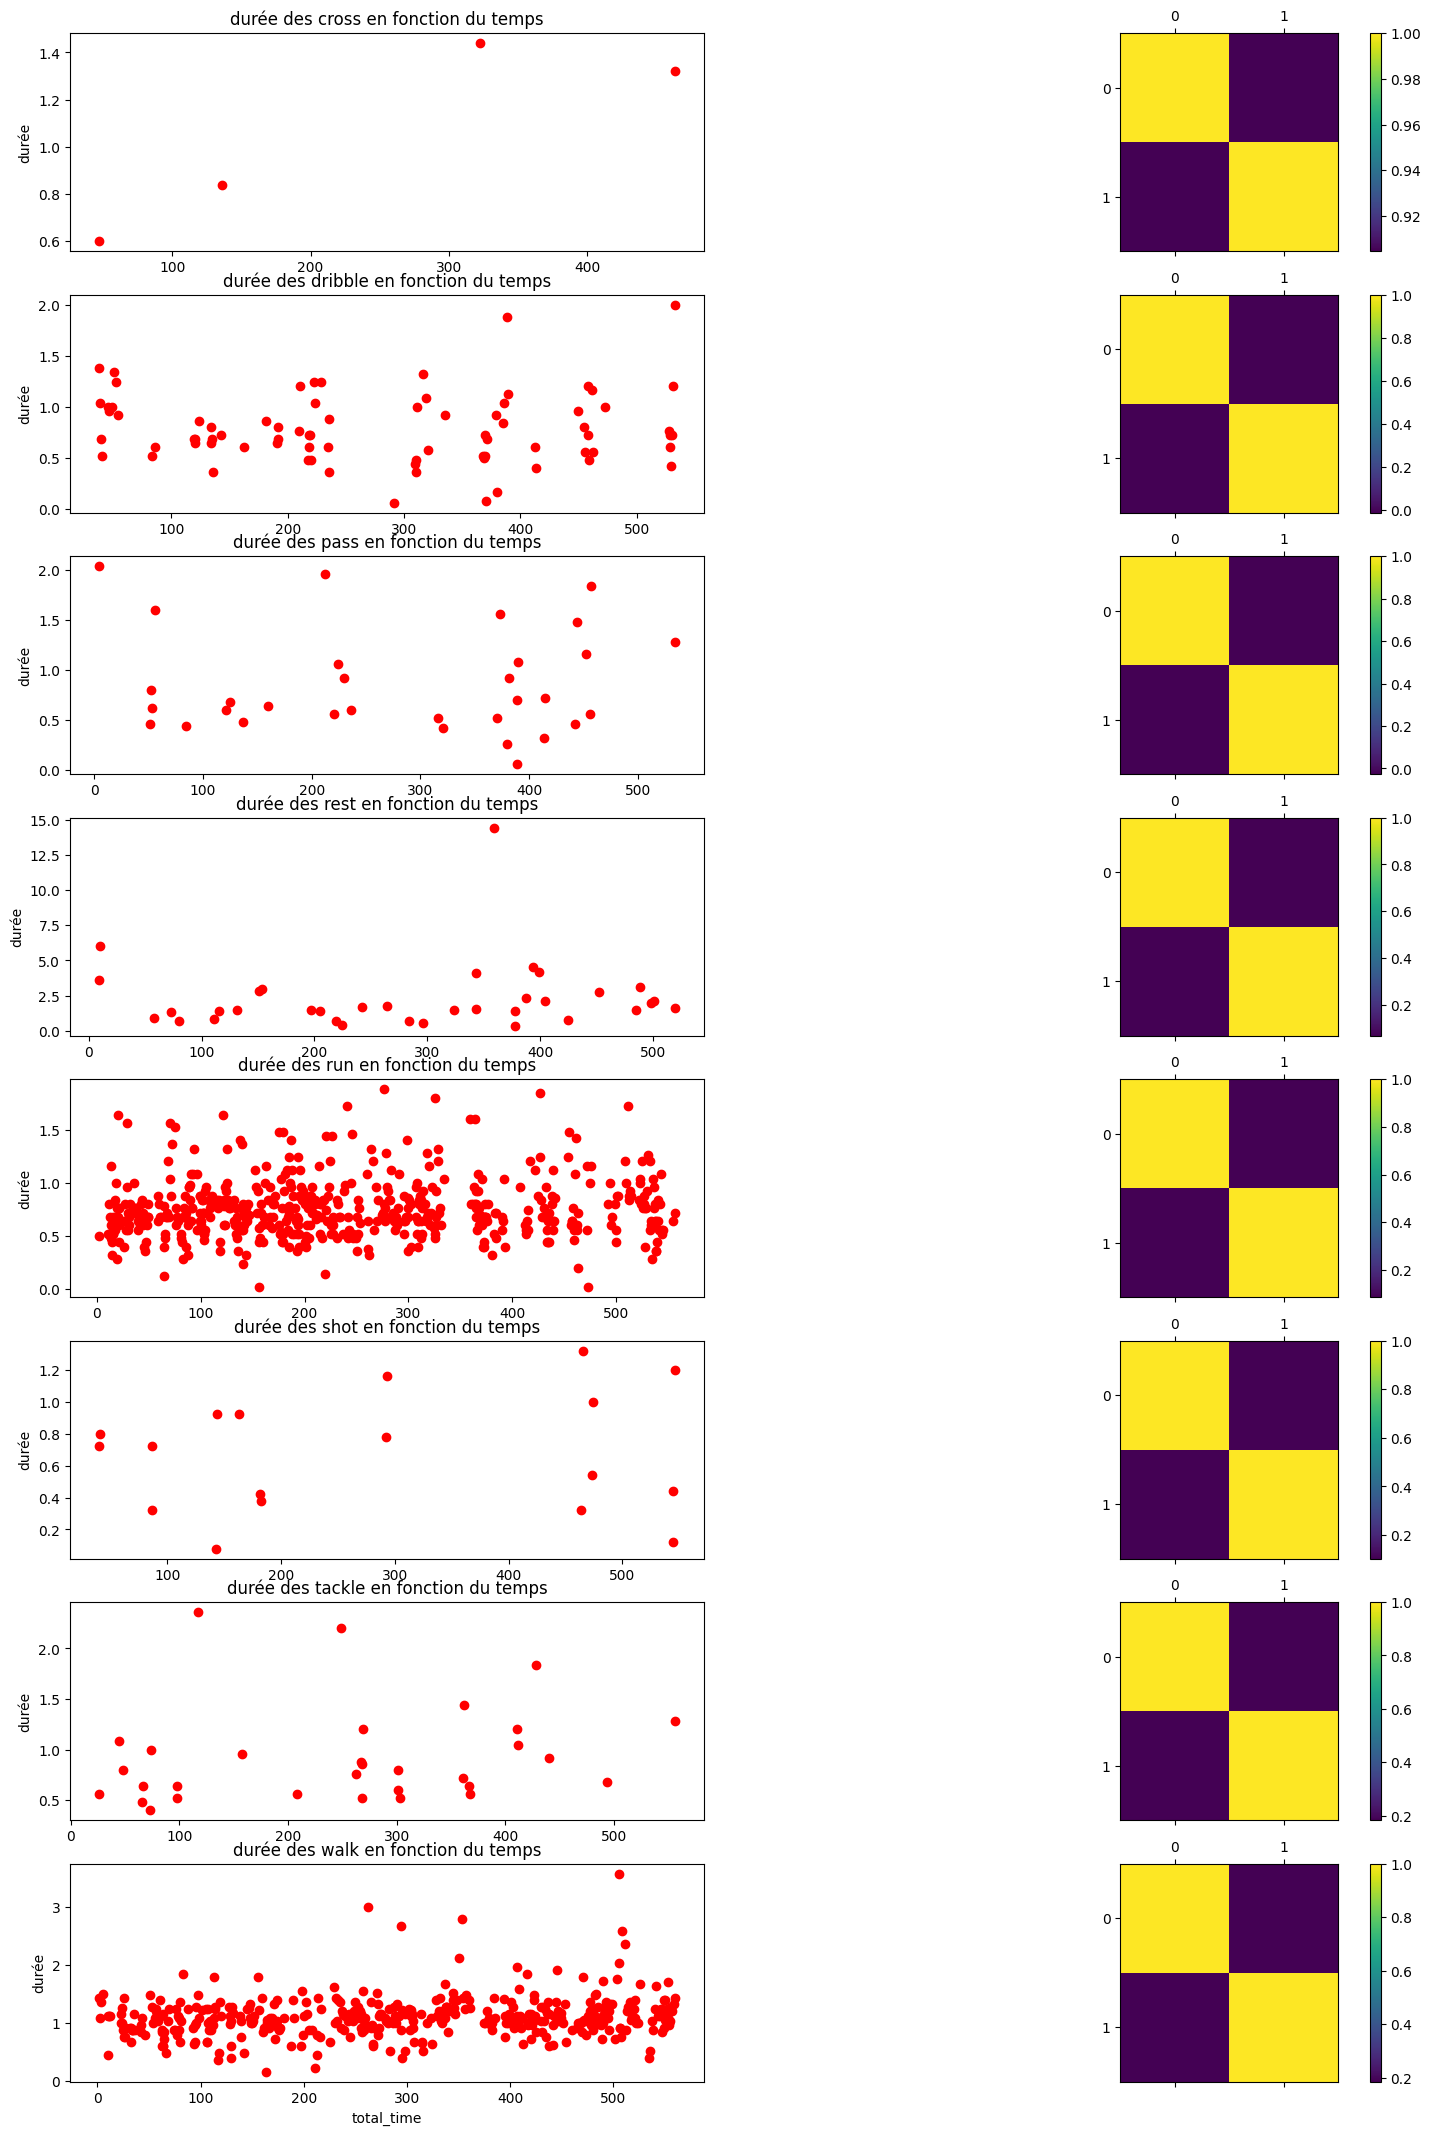

In [16]:
fig = plt.figure(figsize=(18,30))
i = 0
for action in actions:
    df3 = df[df['label'] == action][['total_time', 'total_time_cum']]

    ax1 = plt.subplot(len(actions)+1, 2, 1 + 2*i)
    ax3 = plt.subplot(len(actions)+1, 2, 2 + 2*i)

    ax1.scatter(df3['total_time_cum'], df3['total_time'], c='r')
    ax1.set_title(f"durée des {action} en fonction du temps")
    ax1.set_ylabel('durée')

    i += 1
    
    corr_df3 = df3.corr()
    plt3 = ax3.matshow(corr_df3)
    fig.colorbar(plt3, orientation='vertical')

ax1.set_xlabel('total_time')
ax2.set_xlabel('id_action')


### Distribution des normes et des durées (~size : nombre de points de mesures de l'action)
- On peut donc proposer de modéliser les normes et les sizes comme des distributions
- On choisi pour chacun des labels des distributions telles que: 
    - size suit une distribution normale
    - normes suit une distribution gamma

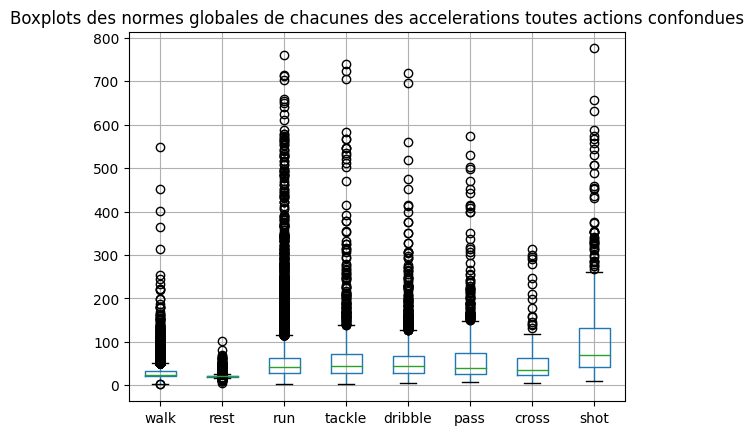

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

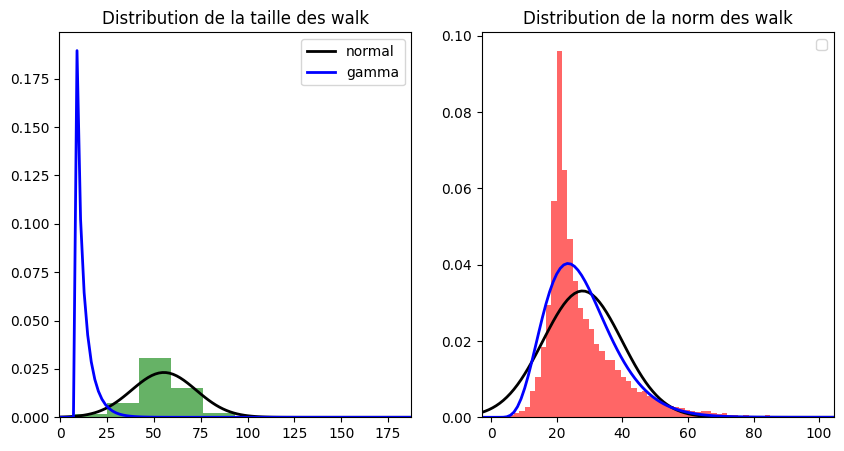

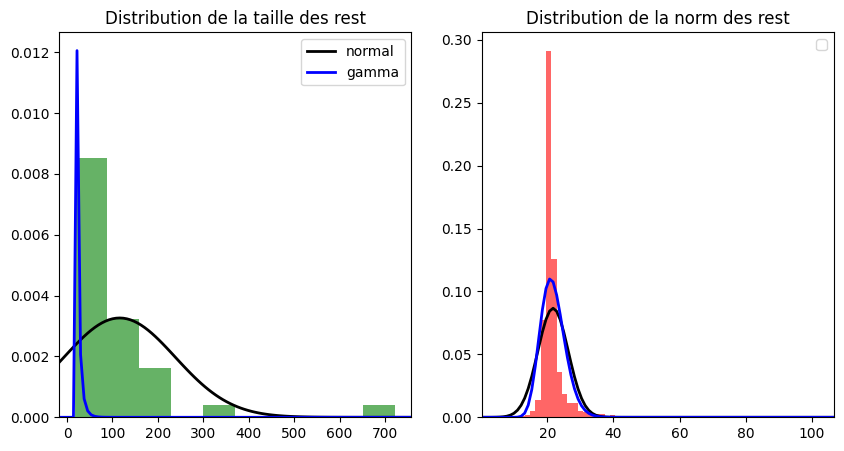

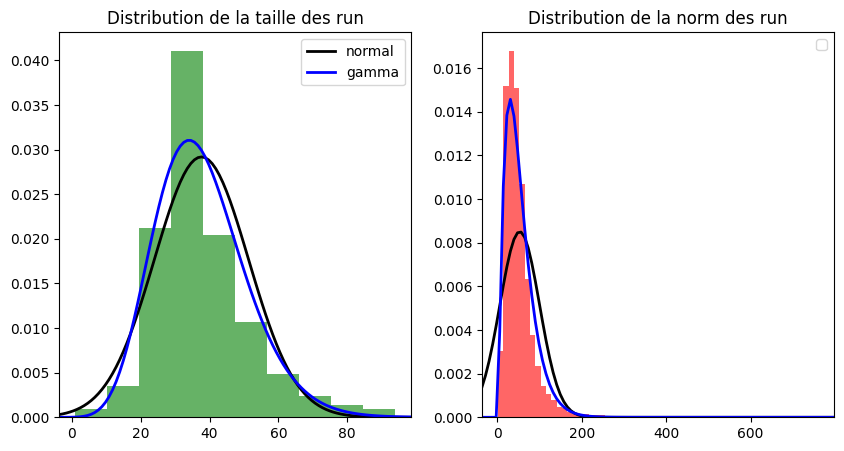

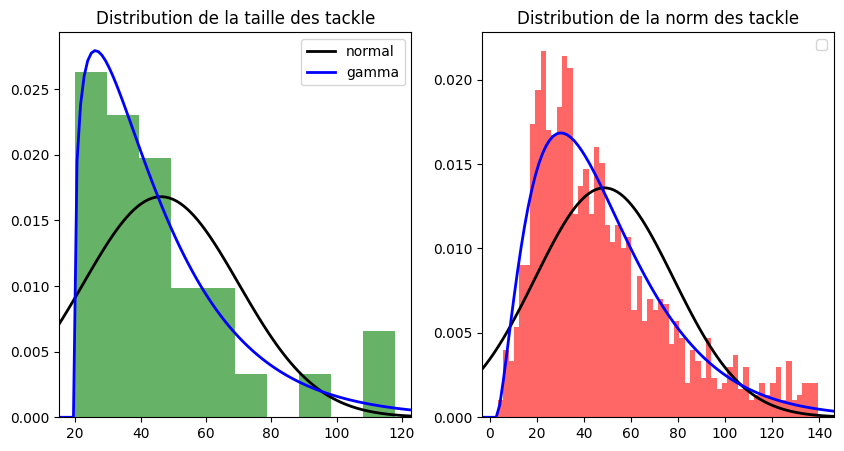

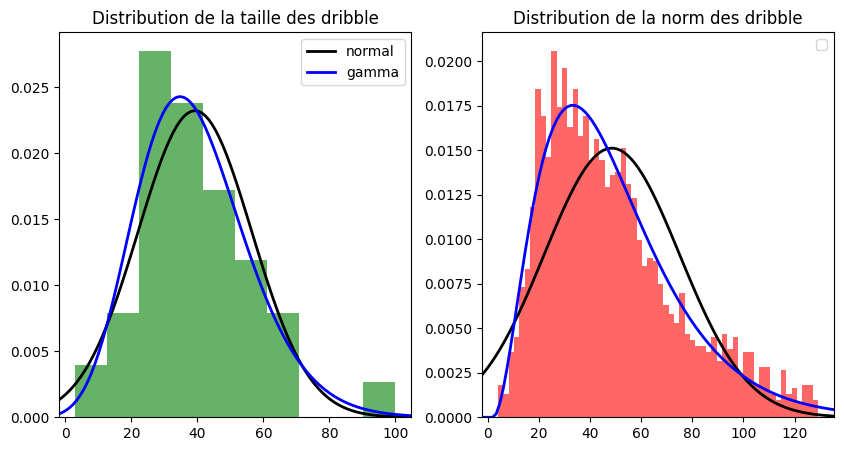

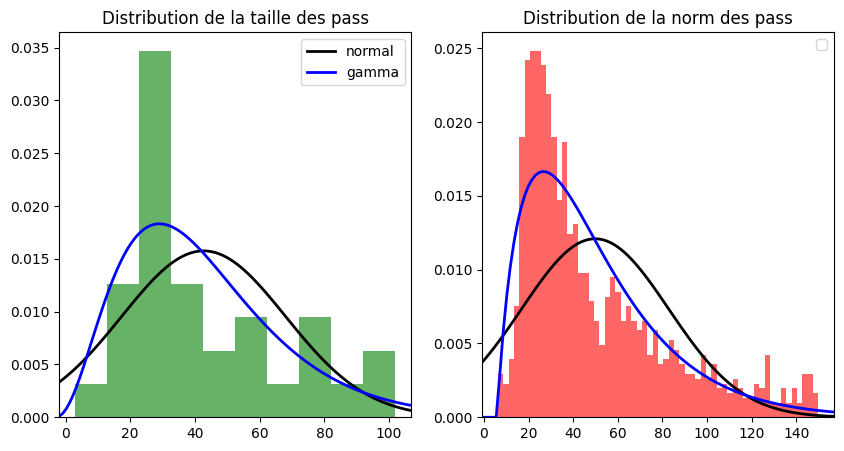

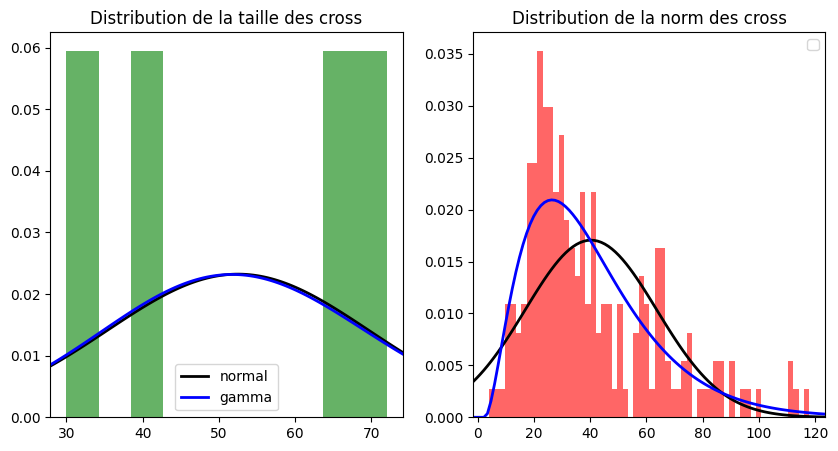

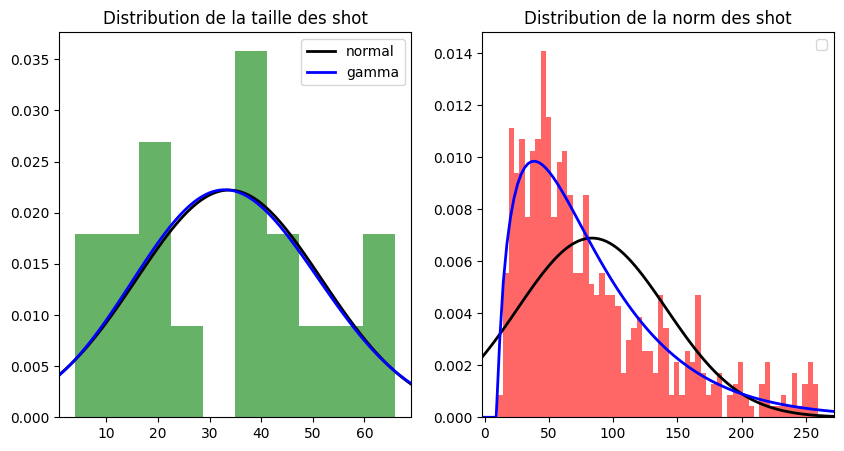

In [19]:
dict_action = {action: [] for action in df["label"].unique()}
dict_limit = {'walk' : 100, 'rest': 1000,'run': 1000, 'tackle': 140, 'dribble': 130, 'pass': 150, 'cross': 120, 'shot': 260}

for action in df["label"].unique():
    df_action = df[df["label"] == action]
    df_action.reset_index(drop=True)
    for k in range(len(df_action)):
        for elmt in df_action["norm"].iloc[k]:
            dict_action[action].append(elmt)

df_action = pd.DataFrame.from_dict(dict_action, orient="index").transpose()
plt.figure()
df_action.boxplot(column=['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'cross', 'shot'])
plt.title("Boxplots des normes globales de chacunes des accelerations toutes actions confondues")
plt.show(block=False)

dict_action_filtered = {action: [] for action in df["label"].unique()}
for action in df["label"].unique():
    df_action = df[df["label"] == action]
    df_action.reset_index(drop=True)
    for k in range(len(df_action)):
        for elmt in df_action["norm"].iloc[k]:
            if elmt < dict_limit[action]:
                dict_action_filtered[action].append(elmt)

dict_size = {"action": [], "alpha": [], "loc": [], "beta": [], "mu": [], "std": [], "min": [], "max": []}
dict_norm = {"action": [], "alpha": [], "loc": [], "beta": [], "mu": [], "std": [], "min": [], "max": []}


def distrib(action):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    data_size = df[df["label"] == action]["size"]
    ax1.hist(data_size, bins=10, density=True, alpha=0.6, color='g')
    fit_alpha, fit_loc, fit_beta = stats.gamma.fit(data_size)
    mu, std = norm.fit(data_size)
    dict_size["action"].append(action)
    dict_size["alpha"].append(fit_alpha)
    dict_size["loc"].append(fit_loc)
    dict_size["beta"].append(fit_beta)
    dict_size["mu"].append(mu)
    dict_size["std"].append(std)
    dict_size["min"].append(data_size.min())
    dict_size["max"].append(data_size.max())
    xmin, xmax = ax1.set_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax1.plot(x, p, 'k', linewidth=2, label ="normal")
    p2 = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
    ax1.plot(x, p2, 'blue', linewidth=2, label ="gamma")
    title_size = f"Distribution de la taille des {action}"
    ax1.legend()
    ax1.set_title(title_size)

    data_norm = dict_action_filtered[action]
    ax2.hist(data_norm, bins=60, density=True, alpha=0.6, color='red')
    fit_alpha, fit_loc, fit_beta = stats.gamma.fit(data_norm)
    mu, std = norm.fit(data_norm)
    dict_norm["action"].append(action)
    dict_norm["alpha"].append(fit_alpha)
    dict_norm["loc"].append(fit_loc)
    dict_norm["beta"].append(fit_beta)
    dict_norm["mu"].append(mu)
    dict_norm["std"].append(std)
    dict_norm["min"].append(np.min(data_norm))
    dict_norm["max"].append(np.max(data_norm))
    xmin, xmax = ax2.set_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax2.legend()
    ax2.plot(x, p, 'k', linewidth=2, label ="normal")
    p2 = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
    ax2.plot(x, p2, 'blue', linewidth=2, label ="gamma")
    title_norm = f"Distribution de la norm des {action}"
    ax2.set_title(title_norm)


# distribution de la taille de chaque actions
for action in df["label"].unique():
    distrib(action)


### 2. les methodes possibles: 
- Linear Regression : souffre d'un manque de complexité, par rapport aux données
- AutoRegressive Integrated Moving Average ARIMA : n'offre pas de flexibilité sur la longueur de la sequence de prédiction, calque les séquences d'entrainement...

In [24]:
def convert_num_to_label(label):
    L = ['rest', 'walk', 'run', 'dribble', 'pass', 'cross', 'shot', 'tackle']
    return L.index(label)
seq_1 = df1["label"].apply(convert_num_to_label)
seq_2 = df2["label"].apply(convert_num_to_label)
seq = np.concatenate([seq_1, seq_2])

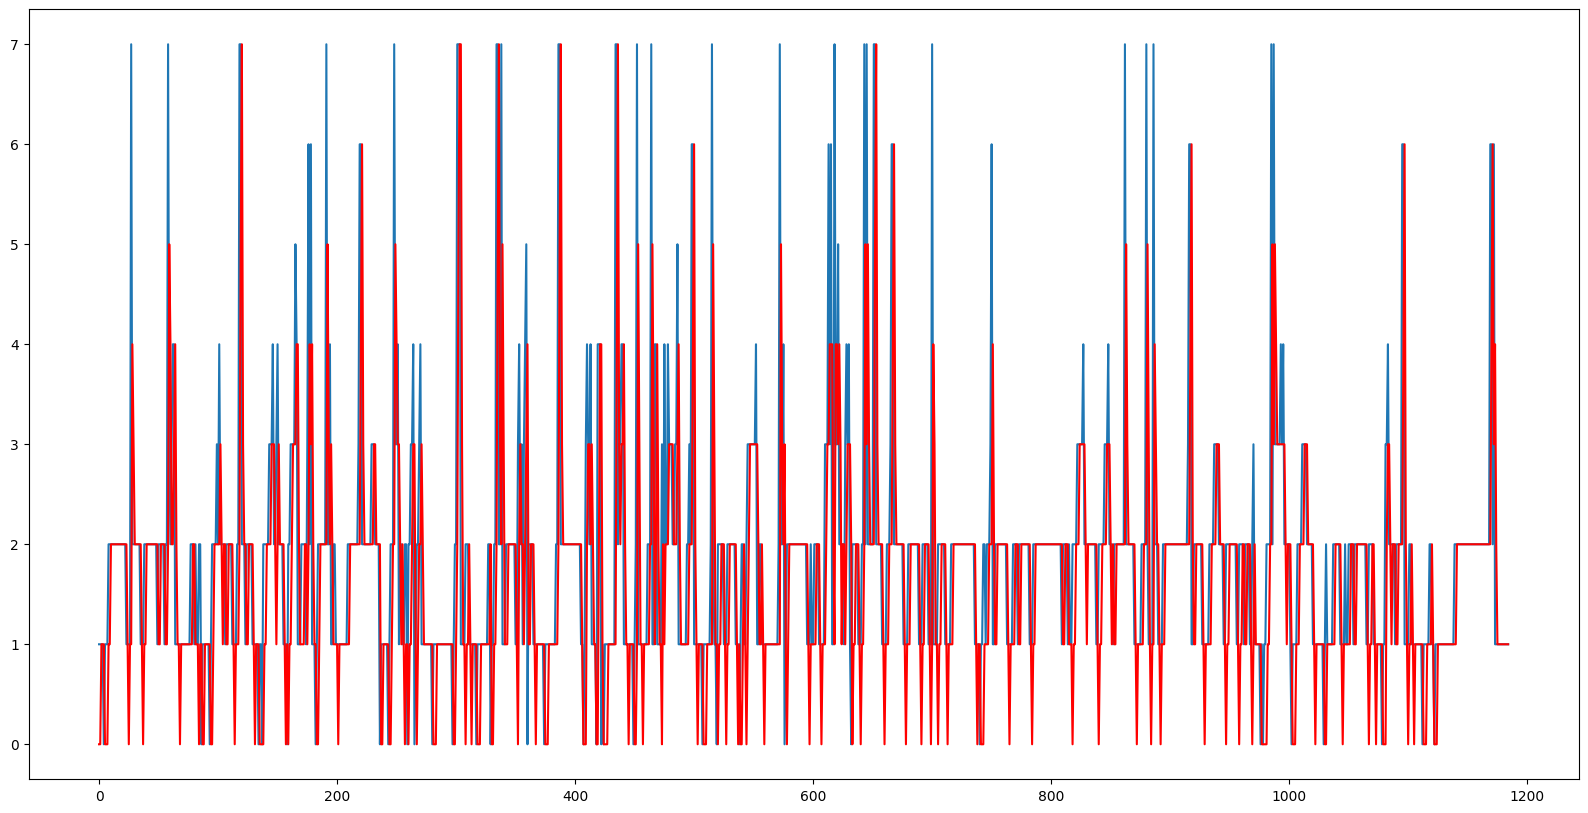

In [43]:
arma = ARIMA(seq, order=(1, 1, 0)).fit()
arma.summary()
pred_1 = arma.predict()
pred_1 = [int(elmt) for elmt in pred_1]
plt.figure(figsize=(20,10))
plt.plot(seq)
plt.plot(pred_1, color = "r")
plt.show()

# 3. Génération de matchs
- On choisi de séparer notre problème en deux étapes: 
    - génération de sequence de jeu telle que ["shot", "run", "run", walk", ...]
    - génération du vecteur de normes associé a chaque action de la sequence de jeu générée précedement.

- la génération des vecteurs de normes se fait à l'aide de tirages dans les lois de distributions calculées au dessus.
- la génération d'une sequence de jeu peut être faite de différentes manières à partir du postulat suivant:
    - on à a disposition deux matchs, soit deux séquences de taille restreintes, qu'on voit comme des séries temporelles, telles que une action est représentée par un entier de 0 à 8.
    - On considère donc qu'on souhaite générer une serie temporelle, à partir de series temporelles d'apprentissage
    

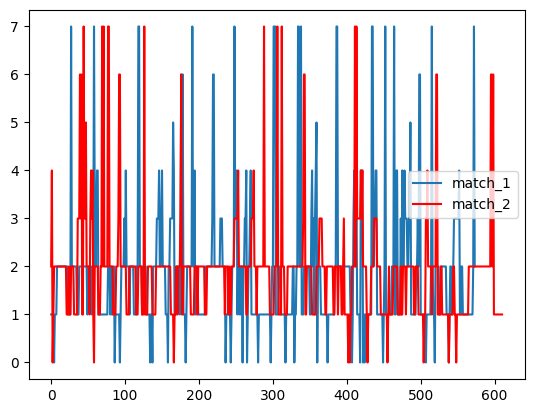

In [38]:
seq_1 = df1["label"].apply(convert_num_to_label)
seq_2 = df2["label"].apply(convert_num_to_label)
seq = np.concatenate([seq_1, seq_2])
plt.plot(seq_1, label="match_1")
plt.plot(seq_2, color="r", label="match_2")
plt.legend()
plt.show(block=False)

# LSTM et CNN
## 4.a et 4.b
Les deux séquences d'actions, vues comme des fonctions, series temporelles, peuvent être traitées par un réseau de neuronnes de type LSTM + CNN.
En effet, on peut choisir de prédire n1 valeurs futures à partir de n2 valeurs passées. Pour cela on va devoir créer un nouveau dataset d'entrement, tel qu'on parcours les deux séquences actuelles avec une fenetre de taille n1+n2, et un pas de 1.

[num_seq_0, num_seq_1, num_seq_2, num_seq_3, num_seq_4, num_seq_5, num_seq_6, num_seq_7, num_seq_8, num_seq_9, num_seq_10, num_seq_11, num_seq_12, num_seq_13, num_seq_14]\
La sequence précédente peut être parcouru par une fenetre de taille 3, avec 2 point passé et un point future tel que :\

[num_seq_1, num_seq_2, num_seq_3] \
[num_seq_2, num_seq_3, num_seq_4] \
[num_seq_3, num_seq_4, num_seq_5] \
[num_seq_4, num_seq_5, num_seq_6] \
[num_seq_5, num_seq_6, num_seq_7] \
[num_seq_6, num_seq_7, num_seq_8] \
...\

Ainsi on à X et y tel que :
X = \
[num_seq_1, num_seq_2] \
[num_seq_2, num_seq_3] \
[num_seq_3, num_seq_4] \
[num_seq_4, num_seq_5] \
[num_seq_5, num_seq_6] \
[num_seq_6, num_seq_7] \
et y = \
[num_seq_3] \
[num_seq_4] \
[num_seq_5] \
[num_seq_6] \
[num_seq_7] \
[num_seq_8]


### Le prétraitement
- On convertis les labels en int, qui correspondent aux indexs dans la liste : ['rest', 'walk', 'run', 'dribble', 'pass', 'cross', 'shot', 'tackle'].
- Il faut supprimer les labels "no action", qui ne permettent pas de générer une action conforme.
- On utilise la fenetre glissante de taille 25 (on choisira n_past = 15 et n_future = 10).
- Il est necessaire de supprimer les doublons après création des X et y, pour un bon apprentissage.

## 5. L'utilisation complète de la génération de match est expliquée dans le Readme